In [1]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# 1-1. GTFS 불러오기
stops = pd.read_csv("./2024-TM-PT-GTFS 대중교통GTFS(2023년 기준)/202303_GTFS_DataSet/stops.txt")
routes = pd.read_csv( './2024-TM-PT-GTFS 대중교통GTFS(2023년 기준)/202303_GTFS_DataSet/routes.txt')
trips = pd.read_csv("./2024-TM-PT-GTFS 대중교통GTFS(2023년 기준)/202303_GTFS_DataSet/trips.txt")
stop_times = pd.read_csv("./2024-TM-PT-GTFS 대중교통GTFS(2023년 기준)/202303_GTFS_DataSet/stop_times.txt")
transfers = pd.read_excel("./2024-TM-PT-GTFS 대중교통GTFS(2023년 기준)/202303_GTFS_도시철도환승정보.xlsx", header=7)  # 컬럼명: Fr_Stop_ID, To_Stop_ID, Time_Min

In [3]:
# 1-2. 경계 데이터 추출
seoul = gpd.read_file('./LSMD_ADM_SECT_UMD_서울/LSMD_ADM_SECT_UMD_11_202509.shp', encoding = 'cp949')
gyeonggi = gpd.read_file('./LSMD_ADM_SECT_UMD_경기/LSMD_ADM_SECT_UMD_41_202509.shp', encoding = 'cp949')
incheon = gpd.read_file('./LSMD_ADM_SECT_UMD_인천/LSMD_ADM_SECT_UMD_28_202509.shp', encoding = 'cp949')
boundary = pd.concat([seoul, gyeonggi, incheon])
boundary = boundary.to_crs(epsg=4326) # 좌표계 변환
boundary

,EMD_CD,COL_ADM_SE,EMD_NM,SGG_OID,geometry
0,11110103,11110,궁정동,1034,"POLYGON ((126.97031 37.58418, 126.97043 37.584..."
1,11110120,11110,신문로1가,1032,"POLYGON ((126.97185 37.5698, 126.97192 37.5698..."
2,11110167,11110,충신동,375,"POLYGON ((127.00856 37.57674, 127.00857 37.576..."
3,11110185,11110,홍지동,374,"POLYGON ((126.95399 37.60475, 126.95404 37.604..."
4,11110154,11110,장사동,368,"POLYGON ((126.9923 37.57001, 126.99247 37.5700..."
...,...,...,...,...,...
151,28720340,28720,대청면,2945,"MULTIPOLYGON (((124.66575 37.82172, 124.66627 ..."
152,28720370,28720,자월면,3686,"MULTIPOLYGON (((126.27897 37.26254, 126.27999 ..."
153,28720360,28720,영흥면,3586,"MULTIPOLYGON (((126.42841 37.2619, 126.42847 3..."
154,28720330,28720,백령면,3786,"POLYGON ((124.61268 37.96987, 124.61431 37.971..."


In [4]:
metro_bus_stops = stops[stops['stop_id'].str.startswith('BS') | stops['stop_id'].str.startswith('RS')]
metro_bus_stops

,stop_id,stop_name,stop_lat,stop_lon
13,BS_1100_100000001,종로2가사거리,37.56977,126.98775
14,BS_1100_100000002,창경궁.서울대학교병원,37.57918,126.99657
15,BS_1100_100000003,명륜3가.성대입구,37.58267,126.99834
16,BS_1100_100000004,종로2가.삼일교,37.56858,126.98761
17,BS_1100_100000005,혜화동로터리.여운형활동터,37.58624,127.00174
...,...,...,...,...
211648,RS_ACC4_H30536,지제,37.01835,127.06957
211649,RS_ACC4_N10230,횡성,37.48194,128.00973
211650,RS_ACC4_N10428,둔내,37.51023,128.22129
211651,RS_ACC4_N10625,평창,37.56257,128.42948


In [5]:
metro_bus_stops_points = gpd.GeoDataFrame(metro_bus_stops, 
                                          geometry = gpd.points_from_xy(metro_bus_stops.stop_lon, metro_bus_stops.stop_lat, crs='EPSG:4326'))

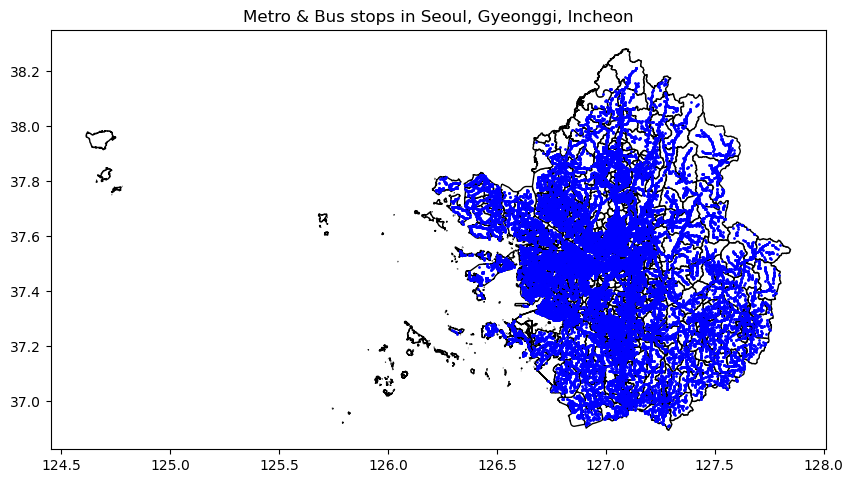

In [ ]:
# 1차 필터링 : 경계 내 정류장 추출
stops_metropolis = gpd.overlay(metro_bus_stops_points, boundary.to_crs(epsg=4326), how = 'intersection')
longitude_cutoff = 126.2  # 최서단의 섬을 제외하기 위한 경도 기준
stops_metropolis = stops_metropolis[stops_metropolis.geometry.x >= longitude_cutoff]

fig, ax = plt.subplots(figsize = (10,10))
boundary.plot(ax=ax, color = 'white', edgecolor = 'black')
stops_metropolis.plot(color = 'blue', markersize=1, ax=ax)
plt.title('Metro & Bus stops in Seoul, Gyeonggi, Incheon')
plt.show()

In [8]:
print(stops_metropolis.nunique())

stop_id       57862
stop_name     31282
stop_lat      37624
stop_lon      38904
EMD_CD         1285
COL_ADM_SE       66
EMD_NM         1176
SGG_OID         942
geometry      57845
dtype: int64


In [9]:
list = ['교동면', '삼산면', '북도면', '자월면', '영흥면']
pattern = '|'.join(list)
mask = stops_metropolis['EMD_NM'].str.contains(pattern)
stops_metropolis = stops_metropolis[~mask]
stops_metropolis

# stops_metropolis = stops_metropolis.drop(stops_metropolis[stops_metropolis['EMD_NM'].isin(list)])
# stops_metropolis

,stop_id,stop_name,stop_lat,stop_lon,EMD_CD,COL_ADM_SE,EMD_NM,SGG_OID,geometry
0,BS_1100_100000001,종로2가사거리,37.56977,126.98775,11110138,11110,종로2가,336,POINT (126.98775 37.56977)
1,BS_1100_100000002,창경궁.서울대학교병원,37.57918,126.99657,11110166,11110,연건동,315,POINT (126.99657 37.57918)
2,BS_1100_100000003,명륜3가.성대입구,37.58267,126.99834,11110172,11110,명륜4가,310,POINT (126.99834 37.58267)
3,BS_1100_100000004,종로2가.삼일교,37.56858,126.98761,11110135,11110,관철동,367,POINT (126.98761 37.56858)
4,BS_1100_100000005,혜화동로터리.여운형활동터,37.58624,127.00174,11110169,11110,혜화동,293,POINT (127.00174 37.58624)
...,...,...,...,...,...,...,...,...,...
57915,RS_ACC4_280090,가남,37.19726,127.53556,41670250,41670,가남읍,2002,POINT (127.53556 37.19726)
57916,RS_ACC4_H10219,광명,37.41649,126.88413,41210106,41210,일직동,1641,POINT (126.88413 37.41649)
57917,RS_ACC4_H30000,수서,37.48555,127.10447,11680115,11680,수서동,1203,POINT (127.10447 37.48555)
57918,RS_ACC4_H30326,동탄,37.20006,127.09542,41590129,41590,오산동,10156,POINT (127.09542 37.20006)


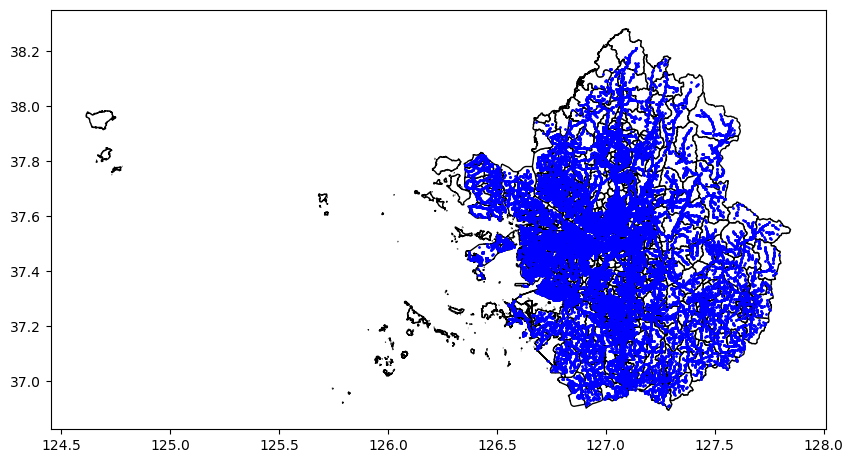

In [10]:
fig, ax = plt.subplots(figsize = (10,10))
boundary.plot(ax=ax, color = 'white', edgecolor = 'black')
stops_metropolis.plot(color = 'blue', markersize=1, ax=ax)
plt.show()

In [11]:
# stops_metropolis.to_file('./stops_metropolis.shp', driver = 'ESRI Shapefile')

In [ ]:
# stops.txt 정의 및 저장
stops = stops_metropolis.copy()
stops.drop(columns = ['EMD_CD', 'COL_ADM_SE', 'EMD_NM', 'SGG_OID', 'geometry'], inplace = True)
stops.reset_index(drop=True, inplace=True)
stops

,stop_id,stop_name,stop_lat,stop_lon
0,BS_1100_100000001,종로2가사거리,37.56977,126.98775
1,BS_1100_100000002,창경궁.서울대학교병원,37.57918,126.99657
2,BS_1100_100000003,명륜3가.성대입구,37.58267,126.99834
3,BS_1100_100000004,종로2가.삼일교,37.56858,126.98761
4,BS_1100_100000005,혜화동로터리.여운형활동터,37.58624,127.00174
...,...,...,...,...
57507,RS_ACC4_280090,가남,37.19726,127.53556
57508,RS_ACC4_H10219,광명,37.41649,126.88413
57509,RS_ACC4_H30000,수서,37.48555,127.10447
57510,RS_ACC4_H30326,동탄,37.20006,127.09542


In [22]:
# 2. stop_times 전처리
stop_id = stops['stop_id'].tolist()
stop_times = stop_times[stop_times['stop_id'].isin(stop_id)]
stop_times

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,timepoint
1124,BR_1100_100000020_Ord001,09:00:00,09:00:00,BS_1100_100000419,1.0,0,0,1
1125,BR_1100_100000020_Ord001,09:01:42,09:01:52,BS_1100_100000415,2.0,0,0,1
1126,BR_1100_100000020_Ord001,09:02:23,09:02:33,BS_1100_100000416,3.0,0,0,1
1127,BR_1100_100000020_Ord001,09:04:20,09:04:30,BS_1100_100000417,4.0,0,0,1
1128,BR_1100_100000020_Ord001,09:05:34,09:05:44,BS_1100_100000418,5.0,0,0,1
...,...,...,...,...,...,...,...,...
20867670,RR_ACC6_0840_U_Ord003,21:25:00,21:26:00,RS_ACC4_130126,39.0,0,0,1
20867671,RR_ACC6_0840_U_Ord003,21:46:00,21:46:00,RS_ACC4_010000,47.0,1,0,1
20867679,RR_ACC6_0840_U_Ord004,23:22:00,23:23:00,RS_ACC4_020524,23.0,0,0,1
20867680,RR_ACC6_0840_U_Ord004,23:49:00,23:51:00,RS_ACC4_130126,39.0,0,0,1


In [23]:
# 3. trips 전처리
trip_id = stop_times['trip_id'].unique().tolist()
trips = trips[trips['trip_id'].isin(trip_id)]
trips

,route_id,service_id,trip_id
0,BR_3100_239000140,B1,BR_3100_239000140_Ord014
1,BR_3100_241222003,B1,BR_3100_241222003_Ord041
2,BR_3100_241224001,B1,BR_3100_241224001_Ord065
3,BR_3100_241224001,B1,BR_3100_241224001_Ord078
4,BR_3100_241224001,B1,BR_3100_241224001_Ord100
...,...,...,...
349569,BR_3100_233000276,B1,BR_3100_233000276_Ord002
349570,BR_3100_234000003,B1,BR_3100_234000003_Ord040
349571,BR_3100_238000050,B1,BR_3100_238000050_Ord001
349573,BR_1100_100100268,B1,BR_1100_100100268_Ord029


In [24]:
# 4. routes 전처리
route_id = trips['route_id'].unique().tolist()
routes = routes[routes['route_id'].isin(route_id)]
routes

,route_id,agency_id,route_short_name,route_long_name,route_type
37,BR_1100_100000020,A1,청와대A01(자율주행),-,0
38,BR_1100_100100001,A1,01,-,0
39,BR_1100_100100006,A1,101,-,0
40,BR_1100_100100007,A1,102,-,0
41,BR_1100_100100008,A1,103,-,0
...,...,...,...,...,...
26979,RR_ACC6_0730_U,A1,[KTX]중부내륙선(상행),충주-부발,6
26980,RR_ACC6_0800_D,A1,[KTX]강릉선(하행),행신-강릉,6
26981,RR_ACC6_0800_U,A1,[KTX]강릉선(상행),강릉-행신,6
26982,RR_ACC6_0840_D,A1,[KTX]강릉선(하행),행신-동해,6


In [25]:
stops.to_csv('./stops.txt', index=False)
stop_times.to_csv('./stop_times.txt', index=False)
trips.to_csv('./trips.txt', index=False)
routes.to_csv('./routes.txt', index=False)